In [68]:
# Import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import representativeClustering as rc

In [69]:
# Load the data file
dataset = pd.read_csv("dataset", header=None, delimiter= ' ')

In [70]:
# dataset.head()

In [71]:
words = dataset[0]
features = dataset.drop(0, 'columns')
features = features.to_numpy()

In [72]:
def distance(x, y):
    return np.linalg.norm(x - y)

In [73]:
def assign(features, clusterRepresentatives):

    '''
    For each feature calculate distance from each cluster representative.
    Assign this feature the representative which is closest to it
    '''
    # The index numbers of clusters array corresponds to the object
    # at same index number in the feature matrix
    # This array shall contain information about the cluster 
    # assigned to the corresponding object in the feature matrix
    clusters = np.zeros((len(features)))

    if clusterRepresentatives.ndim == 1:
        clusterRepresentatives = np.array([clusterRepresentatives])

    for fIndex in range(len(features)):

        # Calculate distance of this feature from each cluster representative
        clusterDistance = [distance(features[fIndex], c) for c in clusterRepresentatives]

        # Find the index number corresponding to the minimum distance
        # This index number also corresponds to the closest cluster representative
        # Thus, the array 'clusters' contain the index number of the cluster 
        # representative which is closest to this object
        clusters[fIndex] = np.argmin(clusterDistance)

    # print(clusters[:5])
    # print('abcdef')
        
    return clusters

In [74]:
def optimise(features, clusters, clusterRepresentatives):

    '''
    For each cluster, find mean of features of all the object
    which are assigned to it. This mean shall be designated
    as the new cluster representative for that cluster
    Return the array of the new cluster representatives
    '''

    for cIndex in range(len(clusterRepresentatives)):
        
        # Find the objects which are assigned to the current cluster
        # This matrix contain feature values of the objects in the
        # current cluster
        objectsInThisCluster = features[clusters == cIndex]

        # Find row-vise mean of all these objects which are assigned
        # to the current cluster
        # This gives, for each feature, mean over all the objects in this cluster
        clusterRepresentatives[cIndex] = np.mean(objectsInThisCluster, axis = 0)
    

    return clusterRepresentatives

In [75]:
# def clustering(features, clusterRepresentatives):

#     # Assignment Phase
#     # Assign cluster representative to each object (i.e., each row of features)
#     clusters = assign(features, clusterRepresentatives)
    
    
#     # Optimisation Phase
#     # Compute new representative as mean of the current clusters
#     clusterRepresentatives = optimise(features, clusters, clusterRepresentatives)

#     return clusters, clusterRepresentatives


In [76]:
def clustering(features, clusterRepresentatives):

    # Assignment Phase
    # Assign cluster representative to each object (i.e., each row of features)
    clusters = assign(features, clusterRepresentatives)

    # This is a safety termination criteria, incase the code takes
    # too long to reach a optimum
    count = 0

    # Repeat till the termination criteria is met
    while True:

        # Optimisation Phase
        # Compute new representative as mean of the current clusters
        updatedclusterRepresentatives = optimise(features, clusters, clusterRepresentatives)

        # Assignment Phase
        # Assign cluster representative to each object (i.e., each row of features)
        updatedClusters = assign(features, updatedclusterRepresentatives)

        # Termination Criteria:
        # Repeat till no object is assigned a new clusters
        # That is, STOP when the older cluster and the updated cluster are equal
        # REPEAT if the cluster assignment of each object stays same
        if (clusters == updatedClusters).all():
            break
        else:
            # Store the updated clusters for checking the termination criteria
            # in the next loop
            clusters = updatedClusters
        
        if count == 100:
            break
        
        count += 1

    return clusters, clusterRepresentatives

In [77]:
def k_means(features, k):

    # Initialisation Phase
    np.random.seed(42)
    initialRandomObjects = np.random.choice(range(features.shape[0]), size=k)

    # Choose initial cluster representatives as randomly chosen objects from the dataset
    initialRepresentatives = features[initialRandomObjects]

    # Perform Clustering based on the inital representatives
    return clustering(features, initialRepresentatives)

In [78]:
def totalClusterDistance(object, clusterObjects):
    # Calculate the total sum of distances between the 'object' and all other 
    # objects in the 'clusterObjects'


    # Initialise sum of distances from the object:
    sumOfObjectDistances = 0

    # Calculate the distance for each object in the given cluster
    # and add it to the previous sum of object distances
    for c in clusterObjects:
        sumOfObjectDistances += distance(object, c)
    
    # Return the sum of distances
    return sumOfObjectDistances

In [79]:
def silhouetteCoefficient(dataset, noOfClusters, clusters):
    
    # Initialise the required parameters

    # 's' is an array of silhoutte coefficient
    # Values of all these array at a given index number corresponds to
    # the object in the dataset at the same index number
    silhoutte = np.zeros((len(clusters)))
    
    # Calculate 'a' and 'b' for each object in the datset
    for i in range(len(clusters)):

        # For each object in the datset, calculate 'a' and 'b', where
        # 'a' is the mean distances between the object and all other points within its cluster
        # 'b' is the mean distances between the object and all other points in the nearest cluster

        # Extract all the data points within the same cluster
        # in which the current object belongs
        clusterObjects = dataset[clusters == clusters[i]]

        # Calculate number of objects in the given cluster;
        # It is required to calculate mean in the further steps
        noOfObjectsInCluster = len(clusterObjects)

        # Silhoutte Coefficient is defined as '0', if the cluster of current
        # object contains just one object
        if noOfObjectsInCluster == 1:
            silhoutte[i] = 0

            # Since the silhoutte coefficient of current object is now defined
            # as '0', further steps can be skipped, and we can continue to 
            # the next object
            continue

        # Calculate 'a' between the current object and objects within its cluster
        a = totalClusterDistance(dataset[i], clusterObjects) / (noOfObjectsInCluster - 1)
        
        # Following loop is to calculate 'b'
        # Initialise next nearest cluster mean
        # This value shall be used to compare the mean distance from 
        # other clusters
        # Initial value is assigned 'infinity', sincee the nearest cluster 
        # distance is unknown
        nextNearestClusterMean = np.inf

        for k in range(noOfClusters):

            # Further operations in this loop are  required only if a cluster
            # is not the one in which the current object lies
            if k != clusters[i]:

                # Extract all the data points from the cluster
                # in which the current object do not belongs
                otherclusterObjects = dataset[clusters == clusters[k]]

                # Calculate number of objects in this other cluster;
                # It is required to calculate mean in the further steps
                noOfObjectsInOtherCluster = len(otherclusterObjects)

                # Find the mean cluster distance from the objects in 
                # this other cluster
                otherClusterMeans = totalClusterDistance(dataset[i], otherclusterObjects) / noOfObjectsInOtherCluster

                # Store this mean distance value, if it less than previously 
                # stored mean distance value
                # This now becomes the mean distance to the next nearest cluster
                if nextNearestClusterMean > otherClusterMeans:
                    nextNearestClusterMean = otherClusterMeans
        
        # After evaluating all the clusters, assign the lowest mean value
        # as 'b'
        # Thus, 'b' becomes the mean distance of the current object to the
        # next nearest cluster
        b = nextNearestClusterMean
        
        # Calculate Silhouette coefficient using 'a' and 'b' calculated above
        # for the current object
        silhoutte[i] = (b - a) / np.max((a, b))
    
    return silhoutte

k = 2 clusters are formed with average silhouette coefficient as 0.09472573622936122
k = 3 clusters are formed with average silhouette coefficient as 0.06379081754865393
k = 4 clusters are formed with average silhouette coefficient as 0.13557553263638242
k = 5 clusters are formed with average silhouette coefficient as 0.14463713307196327
k = 6 clusters are formed with average silhouette coefficient as 0.1511790097007154


c:\Users\songa\AppData\Local\Programs\PythonCodingPack\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\songa\AppData\Local\Programs\PythonCodingPack\lib\site-packages\numpy\core\_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


k = 7 clusters are formed with average silhouette coefficient as -0.003058103975535169
k = 8 clusters are formed with average silhouette coefficient as -0.003058103975535169
k = 9 clusters are formed with average silhouette coefficient as -0.003058103975535169


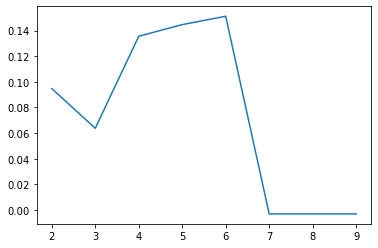

In [80]:
ks = range(2,10)
# ks = [2]
datasetSilihouette = np.zeros(len(ks))
# distMat = distanceMatrix(features)
i = 0
for k in ks:
    clusters, _ = k_means(features, k)
    
    s = silhouetteCoefficient(features, k, clusters)
    # s = silhouette(features, clusterRepresentatives, clusters)
    datasetSilihouette[i] = np.mean(s)
    print(f"k = {k} clusters are formed with average silhouette coefficient as {datasetSilihouette[i]}")
    i += 1

plt.plot(ks, datasetSilihouette)